In [1]:
# Content from Proakis
# Code © 2019, Alexander Kain
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 9 Implementation of Discrete-Time Systems

## 9.1 Structures for the realization of discrete-time systems

A linear time-invariant (LTI) discrete-time systems given by the general constant-coefficient difference equation

$$ y[n] = -\sum_{k=1}^{N-1} a_k y[n-k] + \sum_{k=0}^{M-1} b_k x[n-k] $$

with $z$-transform

$$ H(z) = \frac{\sum_{k=0}^{M-1} b_k z^{-k}}
{1 + \sum_{k=1}^{N-1} a_k z^{-k}} $$

can be implemented in various ways algorithmically, depending on these major factors:

* Computational complexity
* Memory requirements
* Finite-word-length effects

## 9.2  Structures for FIR systems

Given are

$$ y[n] = \sum_{k=0}^{M-1} b_k x[n-k] $$

with $z$-transform

$$ H(z) = \sum_{k=0}^{M-1} b_k z^{-k} $$

Note that the unit sample response of a FIR system is identical to the ${b_k}$ coefficients:

$$ h[n] = \begin{cases}
b_n, & 0 \leq n \leq M-1 \\
0, & \textrm{otherwise}
\end{cases} $$

One implementation that we have already seen elsewhere is via the FFT.

### 9.2.1. Direct-Form Structure

$$ y[n] = \sum_{k=0}^{M-1} b_k x[n - k] $$

In general, this requires $M-1$ memory locations, $M$ multiplications, and $M-1$ additions.

![](Fig9.2.1.jpeg)

In [2]:
def fir_filter(b, x):
    Nb = len(b)
    assert Nb > 1
    zb = np.zeros(Nb - 1)
    y = np.empty_like(x)
    for n in range(len(x)):
        y[n] = b[0] * x[n] + (b[1:] * zb).sum()
        zb[1:] = zb[:-1]  # shift stack
        zb[0] = x[n]   # feed stack
    return y

from scipy.signal import unit_impulse

x = unit_impulse(7)
b = np.array([9, 7, 5, 3, -1, 2])
y = fir_filter(b, x)
y

array([ 9.,  7.,  5.,  3., -1.,  2.,  0.])

In [3]:
# using the library (but this implementation is different as we will see later)
from scipy.signal import lfilter

y2 = lfilter(b, [1], x)  # setting a_0 = 1
assert np.allclose(y2, y)

In [4]:
# equivalent
y2 = np.convolve(b, x)
assert np.allclose(y2[:len(y)],  y)
y2

array([ 9.,  7.,  5.,  3., -1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.])

In [5]:
# equivalent; for very long b, x, or both
from scipy.signal import fftconvolve

y2 = fftconvolve(b, x)  # note numerical precision errors
assert np.allclose(y2[:len(y)],  y)
y2

array([ 9.00000000e+00,  7.00000000e+00,  5.00000000e+00,  3.00000000e+00,
       -1.00000000e+00,  2.00000000e+00,  0.00000000e+00, -4.44089210e-16,
        0.00000000e+00,  2.22044605e-16,  5.55111512e-16, -4.44089210e-16])

### 9.2.2. Cascade-Form Structures

We factor $H(z)$ into second-order systems (SOS) so that

$$ H(z) = \sum_{k=0}^{M-1} b_k z^{-k} = \prod_{k=1}^K H_k(z) $$

where

$$ H_k(z) = b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}$$
and $K$ is $(M + 1) \backslash 2$ (integer division).

The gain factor can be distributed:

$$b_0 = b_{1,0} b_{2,0} \cdots b_{K,0} $$

It is desireable to form pairs of complex-conjugate roots so that the coefficients remain real-valued; real-valued roots can be paired in an arbitrary manner.

The advantage of this structure is that it can provide better numerical precision.

![](Fig9.2.3.jpeg)

In [6]:
# example
x, b

(array([1., 0., 0., 0., 0., 0., 0.]), array([ 9,  7,  5,  3, -1,  2]))

In [7]:
k = b[0]  # gain
z = np.roots(b / k)
z

array([-0.95547214+0.j        , -0.25008834+0.83349746j,
       -0.25008834-0.83349746j,  0.33893552+0.43846708j,
        0.33893552-0.43846708j])

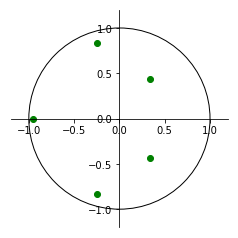

In [8]:
# visualize
from matplotlib.patches import Circle

def zplane(z=np.array([]), p=np.array([])):
    """draw z-plane with poles and zeros"""
    plt.plot(p.real, p.imag, 'rx')  # poles
    plt.plot(z.real, z.imag, 'go')  # zeros
    
    ax = plt.gca()
    ax.add_patch(Circle((0,0), radius=1, fill=False))
    ax.spines['left'].set_position('center') 
    ax.spines['bottom'].set_position('center') 
    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False)
    ax.set_aspect('equal')
    ax.axis([-1.2, 1.2, -1.2, 1.2])
    
zplane(z)

In [9]:
b0 = np.poly(z[0]) 
b1 = np.poly(z[1:3]) * k  # applying gain here, to match later built-in solution
b2 = np.poly(z[3:5])
b0, b1, b2

(array([1.        , 0.95547214]),
 array([9.        , 4.50159008, 6.8153597 ]),
 array([ 1.        , -0.67787104,  0.30713067]))

In [10]:
# check correctness
b_hat = np.convolve(np.convolve(b0, b1), b2)
assert np.allclose(b_hat, b)

In [11]:
y0 = fir_filter(b0, x)
y1 = fir_filter(b1, y0)
y2 = fir_filter(b2, y1) 
assert np.allclose(y2,  y)

In [12]:
# using the library
from scipy.signal import tf2sos, sosfilt

sos = tf2sos(b, [1])  # setting a_0 = 1
sos
# Each row corresponds to a second-order section, 
# with the first three columns providing the numerator coefficients,
# and the last three providing the denominator coefficients.

array([[ 9.        ,  4.50159008,  6.8153597 ,  1.        ,  0.        ,
         0.        ],
       [ 1.        , -0.67787104,  0.30713067,  1.        ,  0.        ,
         0.        ],
       [ 1.        ,  0.95547214,  0.        ,  1.        ,  0.        ,
         0.        ]])

In [13]:
y2 = sosfilt(sos, x)
assert np.allclose(y2,  y)

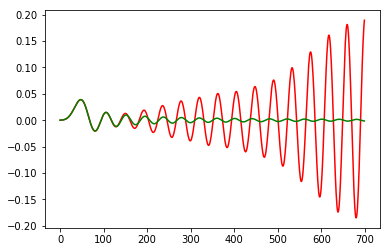

In [14]:
# example from scipy.signal.sosfilt documentation,
# showing the instability that results from trying to 
# do a 13th-order filter in a single stage,
# the numerical error pushes some poles outside of the unit circle
from scipy.signal import ellip  # elliptical filter design 

b, a = ellip(13, 0.009, 80, 0.05, output='ba')  # unstable
sos = ellip(13, 0.009, 80, 0.05, output='sos')  # stable
x = unit_impulse(700)
y_tf = lfilter(b, a, x)
y_sos = sosfilt(sos, x)
plt.plot(y_tf, 'r', label='TF')
plt.plot(y_sos, 'g', label='SOS');

### 9.2.4 Lattice Structure

Consider a *sequence* of FIR filters with system functions

$$ H_m(z) = A_m(z) \quad m=0,1,\ldots, M-1 $$

where

$$ A_m(z) = 1 + \sum_{k=1}^m \alpha_m [k] z^{-k} = \sum_{k=0}^m \alpha_m [k] z^{-k} $$

and $\alpha_0 \equiv 1$ and thus $A_0(z) = 1$. The subscript $m$ denotes the degree of the polynomials.

The unit sample response of the $m^\textrm{th}$ filter is $h_m[k] = \alpha_m [k]$, for $k=1, 2, \ldots, m$. 

Given input $x[n]$ and output $y[n]$ we obtain

$$ y[n] = x[n] + \sum_{k=1}^{m} \alpha_m [k] x[n-k]$$

Suppose $m=1$, then

$$ y[n] = x[n] + \alpha_1[1] x[n-1] $$

This output can be obtained using a first-order or single-stage *lattice* filter:

![](Fig9.2.9.jpeg)

where we let the *reflection coefficient* $K_1 = \alpha_1[1]$.

Now let $m=2$. The output is

$$ y[n] = x[n] + \alpha_2[1] x[n-1] + \alpha_2[2] x[n-2]$$

By cascading the single-stage lattice it is possible to obtain the same output:

![](Fig9.2.10.jpeg)

because 

$$ f_0[n] = g_0[n] = x[n] $$

the output of the first stage is

$$ f_1[n] = f_0[n] + K_1 g_0[n-1] = x[n] + K_1 x[n-1] $$
$$ g_1[n] = K_1 f_0[n] + g_0[n-1] = K_1 x[n] + x[n-1] $$

the top output of the second stage is

$$ y[n] = f_2[n] = f_1[n] + K_2 g_1[n-1] $$
$$ = \left(x[n] + K_1 x[n-1] \right) + K_2 \left( K_1 x[n-1] + x[n-2] \right) $$
$$ = x[n] + K_1 (1 + K_2) x[n-1] + K_2 x [n-2]$$

Comparing to the direct-form equation above we see that $\alpha_2[1] = K_1 (1 + K_2)$ and $\alpha_2[2] = K_2$, or equivalently $K_2 = \alpha_2[2]$ and $K_1 = \alpha_2[1] / (1 + \alpha_2[2])$.

Using a proof by induction, we can demonstrate the equivalence between an $m^\textrm{th}$-order direct-form FIR filter and an $m^\textrm{th}$-order/stage lattice filter, generally described by the following set of order-recursive equations. To start, let $m=0$:

$$ f_0[n] = g_0[n] = x[n] $$

Then, for $m=1, 2, \ldots, M-1$

$$ f_m[n] = f_{m-1}[n] + K_m g_{m-1}[n-1] $$
$$ g_m[n] = K_m f_{m-1}[n] + g_{m-1}[n-1] $$

Finally,

$$y[n] = f_{M-1}[n] $$

![](Fig9.2.11.jpeg)

To convert direct-form filter coefficients to lattice coefficients, let $m=M-1, M-2, \ldots, 1$ and calculate

$$ K_m = \alpha_m [m] $$
$$ \alpha_{m-1}[0] = 1 $$


$$ \alpha_{m-1}[k] = \frac{\alpha_m[k] - \alpha_m[m] \alpha_m[m-k]}{1 - \alpha_m^2[m]} \quad k=1, 2, \ldots, m-1 $$

Note that this requires $|K_m| < 1$, otherwise $A_{m-1}(z)$ has a root on the unit circle, which needs to be factored out first.

In [15]:
# Example 9.2.3

def tf2latc(b):
    M = len(b)
    K = np.zeros(M)
    K[0] = 1  # implicit
    b = b / b[0]
    b1 = np.empty_like(b)  # allocate memory for the new time-step
    for m in range(M - 1, 0, -1):
        K[m] = b[m]
        b1[0] = 1
        for k in range(1, m):
            b1[k] = (b[k] - b[m] * b[m-k]) / (1 - b[m] * b[m])
        b[:] = b1  # switch
    return K

b = np.array([1, 13/24, 5/8, 1/3])
k = tf2latc(b)
k

array([1.        , 0.25      , 0.5       , 0.33333333])

To convert from lattice coefficients to direct-form filter coefficients, let $m=1, 2, \ldots, M-1$ and calculate

$$ \alpha_m[0] = 1 $$
$$ \alpha_m[m] = K_m $$
$$ \alpha_m[k] = \alpha_{m-1}[k] + \alpha_m[m] \alpha_{m-1}[m-k] \quad k=1, 2, \ldots, m-1 $$